In [758]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ast
import requests

import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import markers
from matplotlib import colors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'colors', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [762]:
def html_dict_to_df(url,list_name):
    json_dict = requests.get(url).json()[list_name]
    python_dict = {}
    for d in json_dict:
        for k,v in d.items():
            python_dict.setdefault(k,[]).append(v)
    return pd.DataFrame(python_dict)

fbi_national_ucr_api = 'https://api.usa.gov/crime/fbi/sapi/api/estimates/national?api_key=uAynMrN9U7eOfOXpAfT69WyXcQ67deQaQB7Fggcl'

fbi_national_ucr = html_dict_to_df(fbi_national_ucr_api,'results')
fbi_national_ucr.drop(['state_id','state_abbr'],axis=1,inplace=True)
fbi_national_ucr.sort_values(['year'],inplace=True)
fbi_national_ucr_since2010 = fbi_national_ucr[fbi_national_ucr['year']>2009]
fbi_national_ucr_since2010.reset_index(inplace=True,drop=True)
fbi_national_ucr_since2010

,year,population,violent_crime,homicide,rape_legacy,rape_revised,robbery,aggravated_assault,property_crime,burglary,larceny,motor_vehicle_theft,arson
0,2010,309330219,1251248,14722,85593,NaN,369089,781844,9112625,2168459,6204601,739565,55986
1,2011,311587816,1206031,14661,84175,NaN,354772,752423,9052743,2185140,6151095,716508,54546
2,2012,313873685,1217057,14856,85141,NaN,355051,762009,9001992,2109932,6168874,723186,55336
3,2013,316497531,1168298,14319,82109,113695.0,345093,726777,8651892,1932139,6019465,700288,47204
4,2014,318907401,1153022,14164,84864,118027.0,322905,731089,8209010,1713153,5809054,686803,46195
5,2015,320896618,1199310,15883,91261,126134.0,328109,764057,8024115,1587564,5723488,713063,43993
6,2016,323405935,1285606,17413,96970,132414.0,332797,802982,7928530,1516405,5644835,767290,45729
7,2017,325719178,1283220,17284,99856,135755.0,319356,810825,7694086,1401840,5519107,773139,42323


I haven't done this before, so I'm going to go through step by step doing it with numpy arrays and then do it the easy way with Sklearn (a black box) and compare answers between the two.

#### Import the data
    input X should be array shape (n_samples, n_features), so in this case I have 
        n_samples = years
        n_features = cities

In [260]:
fbi_cities_ucr_since2010 = pd.read_csv(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\fbi_cities_ucr_since2010.csv')

cities_missing_data = list(set(fbi_cities_ucr_since2010[fbi_cities_ucr_since2010['normalized_actual'].isnull()]['city']))
homicides = fbi_cities_ucr_since2010[(fbi_cities_ucr_since2010['offense']=='homicide')&
                                    ~(fbi_cities_ucr_since2010['city'].isin(cities_missing_data))]

yearXcity = pd.pivot_table(homicides[['normalized_actual']],index=homicides['data_year'],columns=homicides['city'])
yearXcity

normalized_actual                                           \
city            Albuquerque   Atlanta    Aurora Baltimore Birmingham   
data_year                                                              
2010               0.767004  2.202028  0.734576  3.593395   0.944867   
2011               0.687408  2.035035  0.360847  3.180020   2.553699   
2012               0.738181  1.870347  0.855874  3.476346   3.147978   
2013               0.664883  1.853307  0.578346  3.745354   2.972638   
2014               0.538433  2.039420  0.254683  3.387964   2.445298   
2015               0.769051  2.026408  0.696631  5.531890   3.675940   
2016               1.090708  2.349177  0.441685  5.173558   3.654526   
2017               1.253227  1.624515  0.816882  5.591451   2.773286   

                                                                      ...      \
city         Boston   Buffalo   Chicago Cleveland Colorado Springs    ...       
data_year                                                             ...       
2010       1.174799  2.105586  1.600693  2.044216         0.476660    ...       
2011       1.008050  1.379289  1.592096  1.879107         0.656651    ...       
2012       0.894095  1.850524  1.841726  2.174341         0.416815    ...       
2013       0.604923  1.815057  1.530093  1.486775         0.591100    ...       
2014       0.807864  2.319298  1.524386  1.617359         0.448612    ...       
2015       0.567614  1.588741  1.768021  2.010004         0.481862    ...       
2016       0.728256  1.712675  2.839223  3.395454         0.494534    ...       
2017       0.834535  1.546838  2.403862  2.775242         0.624368    ...       

                                                                        \
city        Phoenix Pittsburgh  Portland  San Jose   Seattle St. Louis   
data_year                                                                
2010       0.800286   1.798802  0.375793  0.210704  0.311113  4.511900   
2011       0.789393   1.430904  0.335951  0.403110  0.322176  3.552688   
2012       0.826191   1.338942  0.331318  0.457883  0.393986  3.551538   
2013       0.779727   1.471367  0.229082  0.380566  0.275892  3.768655   
2014       0.741683   2.259081  0.419731  0.315024  0.389025  5.009152   
2015       0.716570   1.872628  0.063272  0.292136  0.350650  5.955304   
2016       0.904002   1.877322  0.250143  0.458370  0.241355  6.037174   
2017       0.965509   1.818699  0.370301  0.309073  0.372535  6.642344   

                                                    
city       Stockton     Tampa    Tucson Washington  
data_year                                           
2010       1.673800  0.801318  0.978639   2.183793  
2011       1.957033  0.809099  0.969954   1.747584  
2012       2.382750  0.661585  0.801102   1.391694  
2013       1.073411  0.793244  0.893297   1.593320  
2014       1.620344  0.780631  0.662944   1.593582  
2015       1.603141  0.921339  0.583064   2.409897  
2016       1.595795  0.768880  0.565302   1.981884  
2017       1.771473  1.011875  0.858728   1.671537  

[8 rows x 35 columns]

Assign colors to cities

In [770]:
cities = list(yearXcity['normalized_actual'])

city_colors = {}
city_hom_ave = {}
for city in cities:
    city_df = homicides[homicides['city']==city]
    calc_color = plt.cm.jet(city_df['normalized_actual'].max()/5)
    city_colors[city] = calc_color
    city_hom_ave[city] = city_df['normalized_actual'].mean()
    
city_colors

{'Albuquerque': (0.0, 0.503921568627451, 1.0, 1.0),
 'Atlanta': (0.38899430740037944, 1.0, 0.5787476280834916, 1.0),
 'Aurora': (0.0, 0.17450980392156862, 1.0, 1.0),
 'Baltimore': (0.5, 0.0, 0.0, 1.0),
 'Birmingham': (1.0, 0.6397966594045028, 0.0, 1.0),
 'Boston': (0.0, 0.4411764705882353, 1.0, 1.0),
 'Buffalo': (0.3636938646426312, 1.0, 0.6040480708412397, 1.0),
 'Chicago': (0.7052498418722326, 1.0, 0.26249209361163817, 1.0),
 'Cleveland': (1.0, 0.8576615831517794, 0.0, 1.0),
 'Colorado Springs': (0.0, 0.0176470588235293, 1.0, 1.0),
 'Denver': (0.0, 0.1588235294117647, 1.0, 1.0),
 'Detroit': (0.5, 0.0, 0.0, 1.0),
 'Houston': (0.0, 0.5509803921568628, 1.0, 1.0),
 'Indianapolis': (0.04743833017077798,
  0.9588235294117647,
  0.920303605313093,
  1.0),
 'Kansas City': (0.08538899430740036, 1.0, 0.8823529411764706, 1.0),
 'Laredo': (0.0, 0.0, 0.999108734402852, 1.0),
 'Las Vegas': (0.932953826691967, 1.0, 0.03478810879190386, 1.0),
 'Memphis': (0.844402277039848, 1.0, 0.12333965844402273,

#### 1. Standardize the dataset

In [381]:
X = yearXcity.values # converts dataframe above into numpy array
X_std = StandardScaler().fit_transform(X)
X_std

array([[-0.21010719,  0.97195451,  0.68797275, -0.63873478, -2.24990201,
         1.83989435,  1.10098334, -0.6377923 , -0.21868953, -0.57286036,
        -1.36446557, -0.43173371,  0.98802722, -1.34366981,  0.57742206,
         0.04158338, -0.25085739, -1.53919532,  1.3543179 , -0.59271648,
         0.32483546,  0.80963629,  1.73164744,  0.13073062,  0.64017926,
        -0.19562437,  0.23031698,  0.74016366, -1.75765707, -0.40962508,
        -0.31984849, -0.10387905, -0.17452455,  1.22031802,  1.13118551],
       [-0.56892492,  0.16843564, -1.12097095, -1.06694819, -0.26775941,
         0.95646123, -1.43084931, -0.65690904, -0.49947038,  1.61328841,
        -0.38541615,  0.73407934, -1.40616757, -1.16685513,  0.78037571,
         0.67382908, -0.99912932, -0.70345175,  1.62777663, -1.01008516,
        -0.91326852,  1.69008552,  1.4566909 ,  0.87153401,  1.15392678,
        -0.33644004, -1.06660326,  0.36614023,  0.61299678, -0.1936055 ,
        -1.1565198 ,  0.71525855, -0.09547282,  1.

#### 2. Create a covariance matrix

    mean_vec = np.mean(X_std,axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)

In [262]:
cov_mat = np.cov(X_std.T)
cov_mat

array([[ 1.14285714, -0.19391307,  0.46764211, ...,  0.61944811,
        -0.14749814,  0.14848915],
       [-0.19391307,  1.14285714, -0.52889075, ..., -0.47811037,
        -0.3847166 ,  0.59834689],
       [ 0.46764211, -0.52889075,  1.14285714, ...,  0.23281441,
         0.25494473,  0.08435328],
       ...,
       [ 0.61944811, -0.47811037,  0.23281441, ...,  1.14285714,
        -0.01227857,  0.45271685],
       [-0.14749814, -0.3847166 ,  0.25494473, ..., -0.01227857,
         1.14285714, -0.32311429],
       [ 0.14848915,  0.59834689,  0.08435328, ...,  0.45271685,
        -0.32311429,  1.14285714]])

#### 3. Calculate eigenvectors and eigenvalues
    eigenvalues quantify how much each component contributes to trends seen in cities
    eigenvectors hold weights for each city for each component

In [299]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_vals = eig_vals.real # drops imaginary parts, which are basically zero and probably due to rounding errors
eig_vecs = eig_vecs.real 
eig_vals_sorted = sorted(eig_vals,reverse=True)
print('top 10 eigenvalues: ',eig_vals_sorted[:10])

top 10 eigenvalues:  [15.17358779041949, 6.475352706267845, 4.959585282170628, 4.7301604215099475, 3.8964864728339386, 3.0970772766872217, 1.6677500501109317, 5.6625076303330285e-16, 4.205647070857732e-16, 3.5945248278792723e-16]


In [298]:
eig_dict_all = dict(zip(eig_vals,[eig_vecs[:,n] for n in arange(len(eig_vecs))]))
eig_dict = {k: eig_dict_all[k] for k in eig_vals_sorted[0:6]} # keep the first 7 components - the rest are length zero
eig_dict

{15.17358779041949: array([-0.20865489,  0.01365894, -0.03314501, -0.25983882, -0.15327545,
         0.15894643,  0.07546657, -0.21461779, -0.18926181, -0.01824046,
        -0.23065029,  0.17741294, -0.17598791, -0.2527374 ,  0.1879497 ,
        -0.01636625, -0.23908072, -0.2330692 ,  0.20828025, -0.23609556,
        -0.07786578,  0.18647763,  0.21264806,  0.20378629,  0.0926512 ,
        -0.13822163, -0.1277603 ,  0.10728043, -0.00123785,  0.05146465,
        -0.25524251,  0.08166061, -0.16910353,  0.17614298, -0.08989604]),
 6.475352706267845: array([-0.22006125,  0.09962456, -0.18794908, -0.03458503, -0.0917065 ,
        -0.1167615 ,  0.24088816, -0.20475669, -0.2267798 , -0.09000952,
        -0.17206145, -0.20832217,  0.09664787,  0.10846159,  0.2425828 ,
         0.00994493, -0.0069536 , -0.13122778,  0.03060618, -0.00158721,
        -0.05492727, -0.23590051, -0.06695306, -0.20371219, -0.32288737,
        -0.27982412,  0.27853578, -0.06378696, -0.24866239, -0.0122136 ,
         0.

### Using sklearn

In [637]:
pca = PCA() 
covar_matrix = pca.fit(X_std)
variance = covar_matrix.explained_variance_ #calculate variance ratios
print('variance for first 8 components: ', variance)

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=6)*100)
print('\n cumulative variance as percentage: ',var) #cumulative sum of variance explained with [n] features

components = covar_matrix.components_ 
print('\n components: ',components) # I still don't understand why only 8 components are returned - maybe the remainder
# have eigenvalues = 0?

variance for first 8 components:  [1.51735878e+01 6.47535271e+00 4.95958528e+00 4.73016042e+00
 3.89648647e+00 3.09707728e+00 1.66775005e+00 1.39069372e-31]

 cumulative variance as percentage:  [ 37.934   54.1224  66.5214  78.3468  88.088   95.8307 100.0001 100.0001]

 components:  [[ 0.20865489 -0.01365894  0.03314501  0.25983882  0.15327545 -0.15894643
  -0.07546657  0.21461779  0.18926181  0.01824046  0.23065029 -0.17741294
   0.17598791  0.2527374  -0.1879497   0.01636625  0.23908072  0.2330692
  -0.20828025  0.23609556  0.07786578 -0.18647763 -0.21264806 -0.20378629
  -0.0926512   0.13822163  0.1277603  -0.10728043  0.00123785 -0.05146465
   0.25524251 -0.08166061  0.16910353 -0.17614298  0.08989604]
 [-0.22006125  0.09962456 -0.18794908 -0.03458503 -0.0917065  -0.1167615
   0.24088816 -0.20475669 -0.2267798  -0.09000952 -0.17206145 -0.20832217
   0.09664787  0.10846159  0.2425828   0.00994493 -0.0069536  -0.13122778
   0.03060618 -0.00158721 -0.05492727 -0.23590051 -0.06695306 -

#### Plot first n components

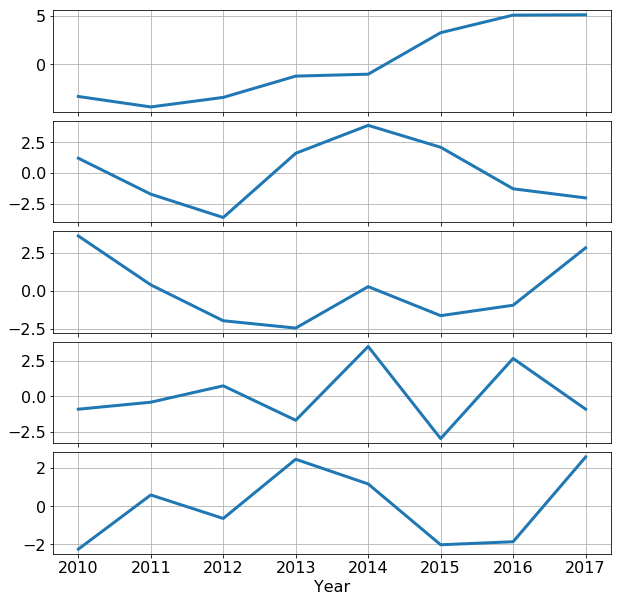

In [663]:
n_components = 5

# rerun PCA and return only n_components with transformation applied for dimensionality reduction
pca_n_components = PCA(n_components)
result = pca_n_components.fit_transform(X_std)


matplotlib.rcParams.update({'font.size': 16})

fig_length = 2*n_components
number_of_plots = n_components
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(10,fig_length))
gs = gridspec.GridSpec(fig_length,number_of_plots)

for n in arange(n_components):

    start = math.floor(plot_length * n)
    end = math.floor(plot_length * (n+1))
    ax = subplot(gs[start:end,0:number_of_plots])

    x = sorted(years)
    y = result[:,n]
    plt.plot(x,y,lw=3)

    # LABEL AXES
    if n+1 != number_of_plots:
        ax.tick_params(labelbottom=False)   
    else:
        plt.xlabel('Year') 
        
    plt.grid()


#### Assign colors to components

In [714]:
component_names = ['component_{0}'.format(n) for n in arange(n_components)]
colors = plt.cm.binary(np.linspace(0.2,1,n_components))

comp_colors = {}
# city_hom_ave = {}
for n,color in enumerate(colors, 1):
    exec("comp_colors['component_{0}'] = {1}".format(str(n),tuple(color)))

    
comp_colors

{'component_1': (0.8, 0.8, 0.8, 1.0),
 'component_2': (0.6, 0.6, 0.6, 1.0),
 'component_3': (0.4, 0.4, 0.4, 1.0),
 'component_4': (0.19999999999999996,
  0.19999999999999996,
  0.19999999999999996,
  1.0),
 'component_5': (0.0, 0.0, 0.0, 1.0)}

In [679]:
yearXcity_df = pd.DataFrame(data=X,index=sorted(list(years)),columns=cities)

for n in arange(n_components): # arange(len(result))
    exec("yearXcity_df['component_{0}'] = result[:,n]".format(str(n+1)))

yearXcity_df

,Albuquerque,Atlanta,Aurora,Baltimore,Birmingham,Boston,Buffalo,Chicago,Cleveland,Colorado Springs,...,St. Louis,Stockton,Tampa,Tucson,Washington,component_1,component_2,component_3,component_4,component_5
2010,0.767004,2.202028,0.734576,3.593395,0.944867,1.174799,2.105586,1.600693,2.044216,0.476660,...,4.511900,1.673800,0.801318,0.978639,2.183793,-3.315713,1.188974,3.598445,-0.904853,-2.248185
2011,0.687408,2.035035,0.360847,3.180020,2.553699,1.008050,1.379289,1.592096,1.879107,0.656651,...,3.552688,1.957033,0.809099,0.969954,1.747584,-4.391595,-1.738338,0.379947,-0.415323,0.585764
2012,0.738181,1.870347,0.855874,3.476346,3.147978,0.894095,1.850524,1.841726,2.174341,0.416815,...,3.551538,2.382750,0.661585,0.801102,1.391694,-3.410353,-3.639079,-1.981908,0.731598,-0.641713
2013,0.664883,1.853307,0.578346,3.745354,2.972638,0.604923,1.815057,1.530093,1.486775,0.591100,...,3.768655,1.073411,0.793244,0.893297,1.593320,-1.223305,1.589413,-2.464012,-1.680059,2.451486
2014,0.538433,2.039420,0.254683,3.387964,2.445298,0.807864,2.319298,1.524386,1.617359,0.448612,...,5.009152,1.620344,0.780631,0.662944,1.593582,-1.024659,3.862993,0.262914,3.484962,1.161294
2015,0.769051,2.026408,0.696631,5.531890,3.675940,0.567614,1.588741,1.768021,2.010004,0.481862,...,5.955304,1.603141,0.921339,0.583064,2.409897,3.241124,2.080867,-1.647797,-2.965076,-2.017131
2016,1.090708,2.349177,0.441685,5.173558,3.654526,0.728256,1.712675,2.839223,3.395454,0.494534,...,6.037174,1.595795,0.768880,0.565302,1.981884,5.046493,-1.300802,-0.961193,2.648683,-1.857994
2017,1.253227,1.624515,0.816882,5.591451,2.773286,0.834535,1.546838,2.403862,2.775242,0.624368,...,6.642344,1.771473,1.011875,0.858728,1.671537,5.078009,-2.044028,2.813603,-0.899932,2.566478


In [685]:
X = yearXcity_df.values # converts dataframe above into numpy array
X_std = StandardScaler().fit_transform(X)
X_std.shape

(8, 40)


#### Correlation coefficient between homicide counts from 2010-2017 for all 35 cities and n components

In [688]:
corr_coef = numpy.corrcoef(X_std.T)
corr_mat = pd.DataFrame(data=corr_coef,index=list(yearXcity_df), columns=list(yearXcity_df))


# only keep city pairs that have a correlation coefficient of 0.65 
corr_mat_filt = corr_mat[corr_mat>=0.65]
corr_mat_filt

,Albuquerque,Atlanta,Aurora,Baltimore,Birmingham,Boston,Buffalo,Chicago,Cleveland,Colorado Springs,...,St. Louis,Stockton,Tampa,Tucson,Washington,component_1,component_2,component_3,component_4,component_5
Albuquerque,1.000000,NaN,NaN,0.773307,NaN,NaN,NaN,0.881163,0.870796,NaN,...,0.718642,NaN,NaN,NaN,NaN,0.760286,NaN,NaN,NaN,NaN
Atlanta,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aurora,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baltimore,0.773307,NaN,NaN,1.000000,NaN,NaN,NaN,0.705927,NaN,NaN,...,0.897905,NaN,0.701864,NaN,NaN,0.946787,NaN,NaN,NaN,NaN
Birmingham,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boston,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.660181,NaN,NaN,NaN,0.722607,NaN,NaN
Buffalo,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chicago,0.881163,NaN,NaN,0.705927,NaN,NaN,NaN,1.000000,0.975923,NaN,...,0.676826,NaN,NaN,NaN,NaN,0.782013,NaN,NaN,NaN,NaN
Cleveland,0.870796,NaN,NaN,NaN,NaN,NaN,NaN,0.975923,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0.689622,NaN,NaN,NaN,NaN
Colorado Springs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### How well correlated are component_1 and the national homicide rate?

In [794]:
nat_comp1_df = pd.DataFrame({'national':fbi_national_ucr_since2010['homicide']/fbi_national_ucr_since2010['population']*10000,
                          'component_1':result[:,0]})
nat_comp1_ar = nat_comp1_df.values # converts dataframe above into numpy array
nat_comp1_std = StandardScaler().fit_transform(nat_comp1_ar)

nat_comp1_corr = numpy.corrcoef(nat_comp1_std.T)
nat_comp1_corr_mat = pd.DataFrame(data=nat_comp1_corr,index=list(nat_comp1_df), columns=list(nat_comp1_df))
nat_comp1_corr_mat

,national,component_1
national,1.000000,0.802634
component_1,0.802634,1.000000


In [ ]:
corr_coef = numpy.corrcoef(X_std.T)
corr_mat = pd.DataFrame(data=corr_coef,index=list(yearXcity_df), columns=list(yearXcity_df))


# only keep city pairs that have a correlation coefficient of 0.65 
corr_mat_filt = corr_mat[corr_mat>=0.65]
corr_mat_filt

#### I tried unioning all groups (i.e. if two groups shared one or more cities, I combined them), but this resulted in all but a few cities being grouped back together, so nevermind (I think it's OK for a city to belong to more than one group)

In [593]:
# # cities = list(corr_mat_filt)
# city_groups = []
# for c in cities:
#     if c in cities:
#         group = list(corr_mat_filt[corr_mat_filt[c].notnull()==True].index)
#         city_groups.append(set(group))
#         cities = set(cities) - set(group)
        
# city_groups = sorted(city_groups)

# def union_lists(list_of_lists):
#     unioned_groups = []
#     for cg1 in list_of_lists[:]:
#         if cg1 in list_of_lists[:]:
#             list_of_lists.remove(cg1)
#             for cg2 in list_of_lists[:]:
#                 if len(cg1&cg2)>0:
#                     cg1 = cg1.union(cg2)
#                     list_of_lists.remove(cg2)
#             unioned_groups.append(cg1)       
#     return unioned_groups

# # NEED TO RUN IT TWICE TO COMPLETELY UNION EVERYTHING
# unioned_city_groups = union_lists(city_groups)
# unioned_city_groups = union_lists(unioned_city_groups)

# list_of_str = list(set([str(sorted(list(x))) for x in unioned_city_groups]))
# unioned_city_groups = [(ast.literal_eval(x)) for x in list_of_str]
# print(len([item for sublist in unioned_city_groups for item in sublist]))
# unioned_city_groups

35


[['Kansas City', 'Miami'],
 ['Atlanta'],
 ['Laredo'],
 ['Buffalo'],
 ['Aurora', 'Minneapolis'],
 ['Albuquerque',
  'Baltimore',
  'Birmingham',
  'Boston',
  'Chicago',
  'Cleveland',
  'Denver',
  'Detroit',
  'Houston',
  'Indianapolis',
  'Las Vegas',
  'Memphis',
  'Milwaukee',
  'New Orleans',
  'New York',
  'Oakland',
  'Philadelphia',
  'Phoenix',
  'Pittsburgh',
  'Portland',
  'San Jose',
  'St. Louis',
  'Stockton',
  'Tampa',
  'Tucson',
  'Washington'],
 ['Colorado Springs'],
 ['Seattle']]

#### Plot city groups together

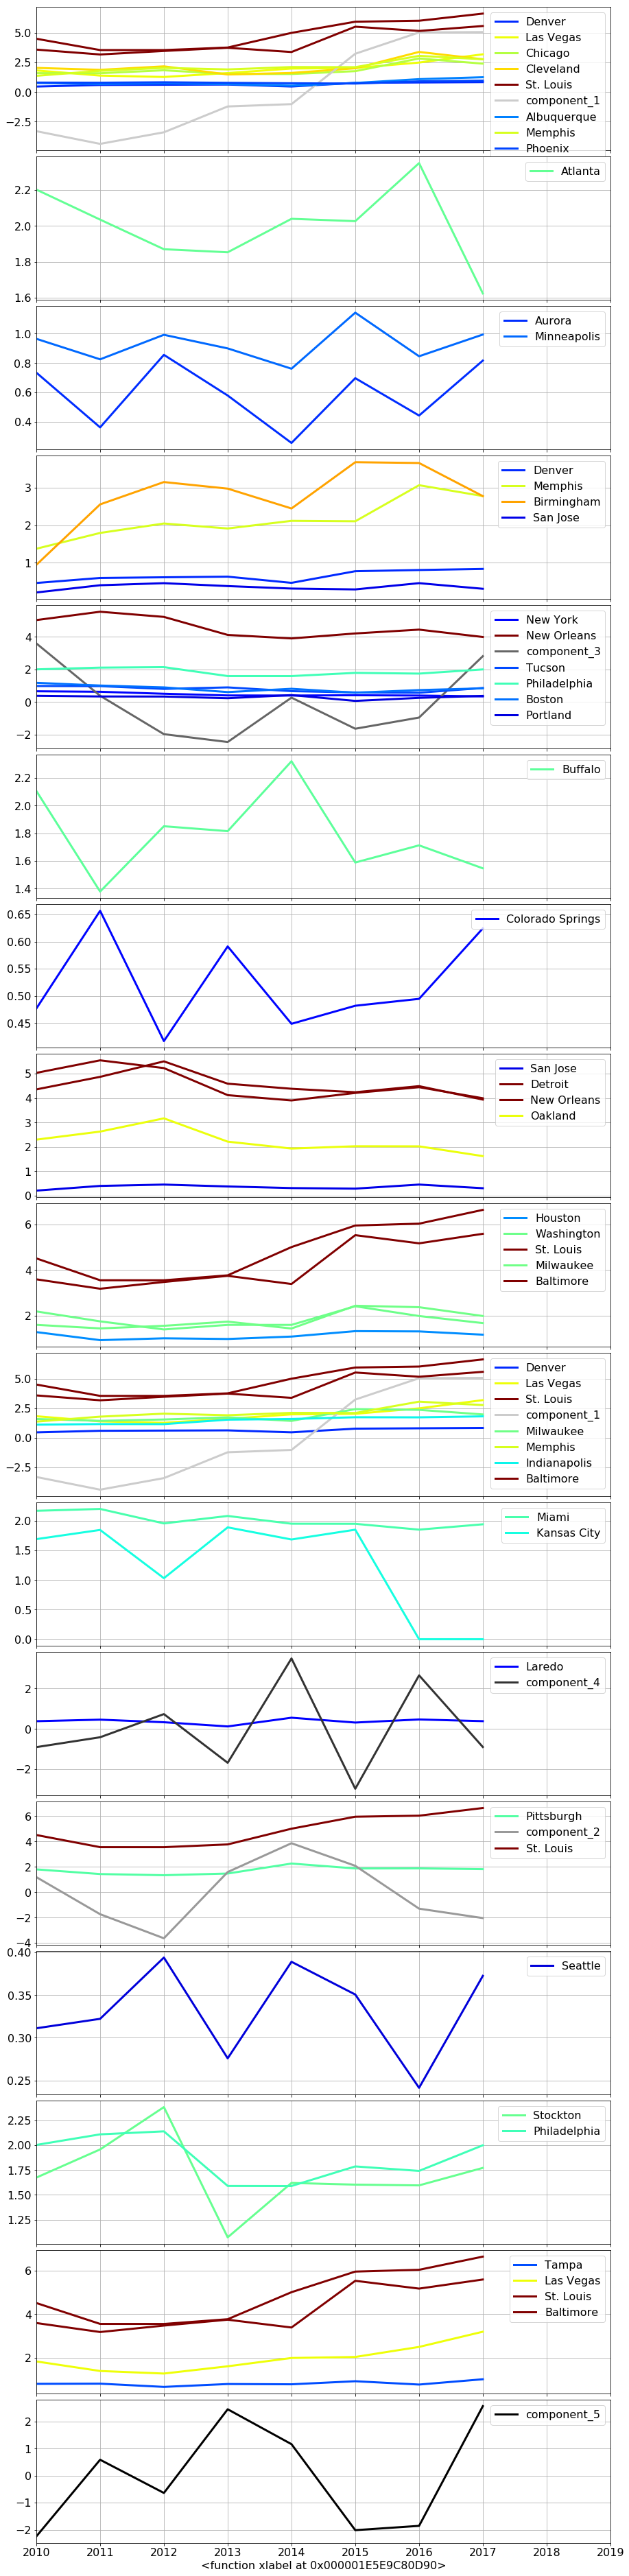

In [755]:
cities = list(corr_mat_filt)
city_groups = []
for c in cities:
    if c in cities:
        group = list(corr_mat_filt[corr_mat_filt[c].notnull()==True].index)
        city_groups.append(set(group))
        cities = set(cities) - set(group)
        
city_groups = sorted(city_groups)

# combine city and component colors
all_colors = city_colors.copy()
all_colors.update(comp_colors)

    
n_plots = len(city_groups)

matplotlib.rcParams.update({'font.size': 16})

fig_length = 4*n_plots
number_of_plots = n_plots
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(15,fig_length))
gs = gridspec.GridSpec(fig_length,number_of_plots)

for n,cg in zip(arange(n_plots),city_groups):

    start = math.floor(plot_length * n)
    end = math.floor(plot_length * (n+1))
    ax = subplot(gs[start:end,0:number_of_plots])
    
    for city in cg:
        plt.plot(list(yearXcity_df[city].index),
                 list(yearXcity_df[city]),
                 label=city,c=all_colors[city],lw=3)
    plt.grid()
    plt.legend(loc=1)
    plt.xlim((2010, 2019))   

    # LABEL AXES
    if n+1 != number_of_plots:
        ax.tick_params(labelbottom=False)   
    else:
        plt.xlabel(xlabel) 

In [819]:
pd_reforms_all = pd.read_csv(r'C:\Users\1017298\Desktop\Geophysics\Jobs\DataIncubator\Police_reforms_by_city.csv')
pd_reforms_all

,City,State,Type,Year Entered
0,Baltimore,MD,Consent Decree,2017
1,Yonkers,NY,MOA,2016
2,Newark,NJ,Consent Decree,2016
3,Ferguson,MO,Consent Decree,2016
4,Miami,FL,MOA,2016
5,Albuquerque,NM,Consent Decree,2015
6,Porland,OR,Consent Decree,2014
7,Missoula,MT,MOA,2013
8,New Orleans,LA,Consent Decree,2013
9,East Haven,CT,Consent Decree,2012


#### cities in reform agreements (mostly consent decrees) with the DOJ

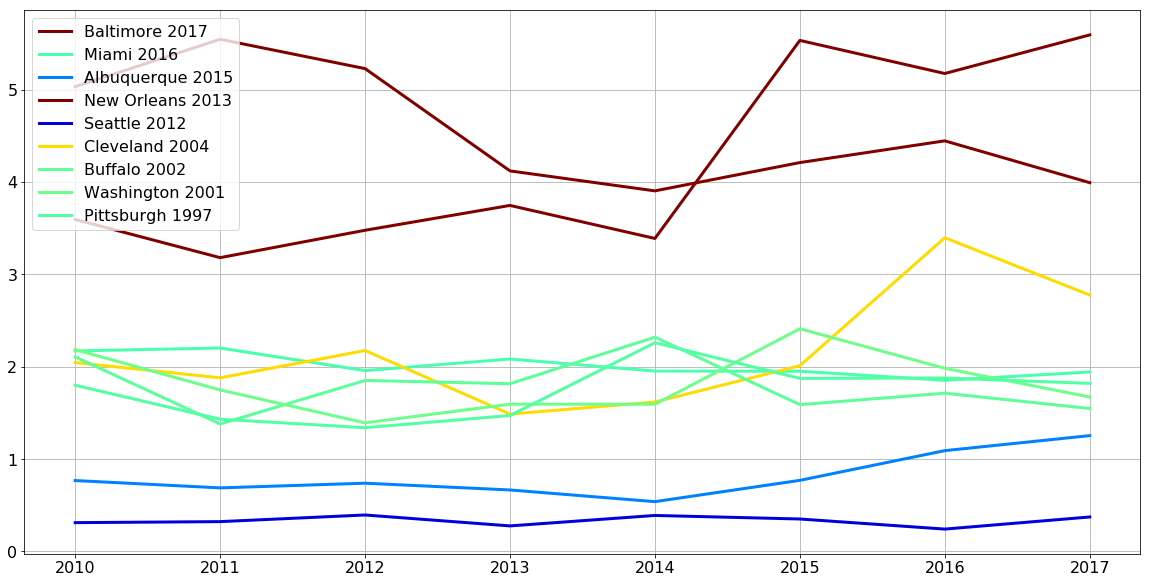

In [828]:
pd_reforms = pd_reforms_all[pd_reforms_all['City'].isin(cities)]

plt.figure(figsize=(20,10))

matplotlib.rcParams.update({'font.size': 16})

for city,year in zip(pd_reforms['City'],pd_reforms['Year Entered']):
    plt.plot(list(yearXcity_df[city].index),
         list(yearXcity_df[city]),
         label='{0} {1}'.format(city,year),c=all_colors[city],lw=3)
    
plt.grid()
plt.legend()

#### Compare census data to components

In [739]:
census_data = pd.read_csv('all_data_2010_2017.csv')
census_data.drop(census_data.columns[0],axis=1,inplace=True)

# SELECT CENSUS DATA WE WANT TO POT (SEE CELL BELOW)
data_select = ['B01002_001E','B19301_001E','B01003_001E','B19058_003E']
data_select_dict = {}
for k,v in my_variable_dictionary.items():
    if k in data_select:
        data_select_dict[k] = v
        
print(data_select_dict)

census_data_select = census_data[['city','year','B01002_001E','B19301_001E','B01003_001E']] #'B19058_003E'
census_data_select.rename(data_select_dict,axis=1,inplace=True)

cities = list(yearXcity['normalized_actual'])
census_data_select = census_data_select[census_data_select['city'].isin(cities)]
census_data_select.sort_values(['year'],inplace=True)
census_data_select.reset_index(drop=True,inplace=True)
census_data_select

{'B01002_001E': 'Median age total', 'B19058_003E': 'No cash public assistance or food stamps/snap', 'B19301_001E': 'Per capita income ', 'B01003_001E': 'Total population'}


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,city,year,Median age total,Per capita income,Total population
0,Washington,2010,33.9,41240.0,604453.0
1,Milwaukee,2010,30.5,17912.0,595587.0
2,Miami,2010,39.1,18269.0,400892.0
3,Memphis,2010,33.4,20237.0,647870.0
4,Las Vegas,2010,36.8,24360.0,584641.0
5,Laredo,2010,27.5,14117.0,237244.0
6,Kansas City,2010,32.7,17577.0,147798.0
7,Minneapolis,2010,31.7,29558.0,383280.0
8,Indianapolis,2010,33.6,22022.0,824199.0
9,Detroit,2010,35.1,14118.0,711910.0


#### Look at trends in cities that correlate to component 1 versus cities that don't

In [801]:
trend1 = [cg for cg in city_groups if 'component_1' in cg]
trend1 = set([city for cg in trend1 for city in cg])

not_trend1 = [cg for cg in city_groups if 'component_1' not in cg]
not_trend1 = set([city for cg in not_trend1 for city in cg])


Text(0.5,1,'Median age total')

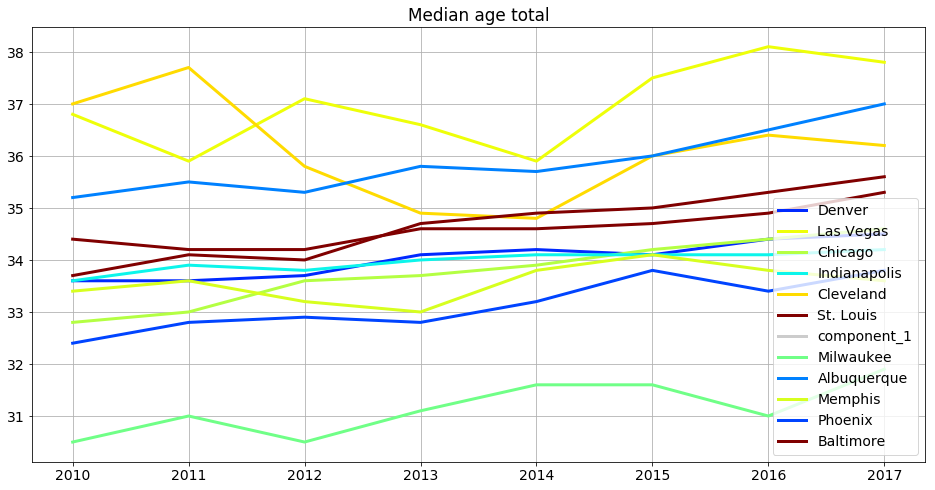

In [837]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(20,20)

# variable = 'Per capita income '
# variable = 'Total population'
variable = 'Median age total'


# cities_subset = ['San Jose','New Orleans','Detroit','Oakland']
cities_subset = trend1

for city,color in zip(cities_subset,plt.cm.jet(np.linspace(0,1,len(cities_subset)))):
# for city,color in zip(cities,plt.cm.jet(np.linspace(0,1,len(cities)))):
#     plt.plot(yearXcity_df.index,yearXcity_df[city],lw=3,c=color,label=city)
    city_df = census_data_select[census_data_select['city']==city]
    plt.plot(city_df['year'],city_df[variable],label=city,c=all_colors[city],lw=3)
    


plt.legend()
plt.grid()
plt.title(variable)
# plt.ylim(0,10**6)

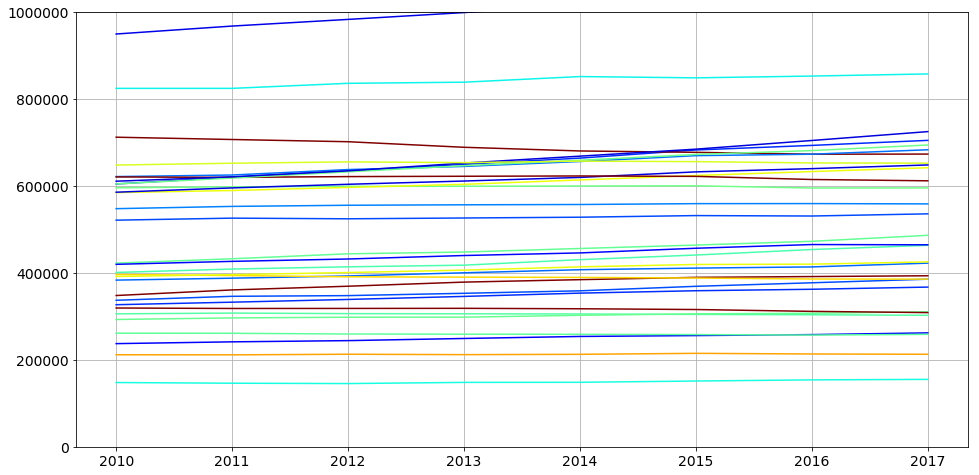

In [771]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(20,20)


# variable = 'Per capita income '
variable = 'Total population'

cities = set(census_data_select['city'])

for city in cities:
    city_df = census_data_select[census_data_select['city']==city]
    plt.plot(city_df['year'],city_df[variable],color=city_colors[city])
    
plt.ylim((0, 10**6))
plt.grid()

Text(0.15,0.5,'National homicide rate')

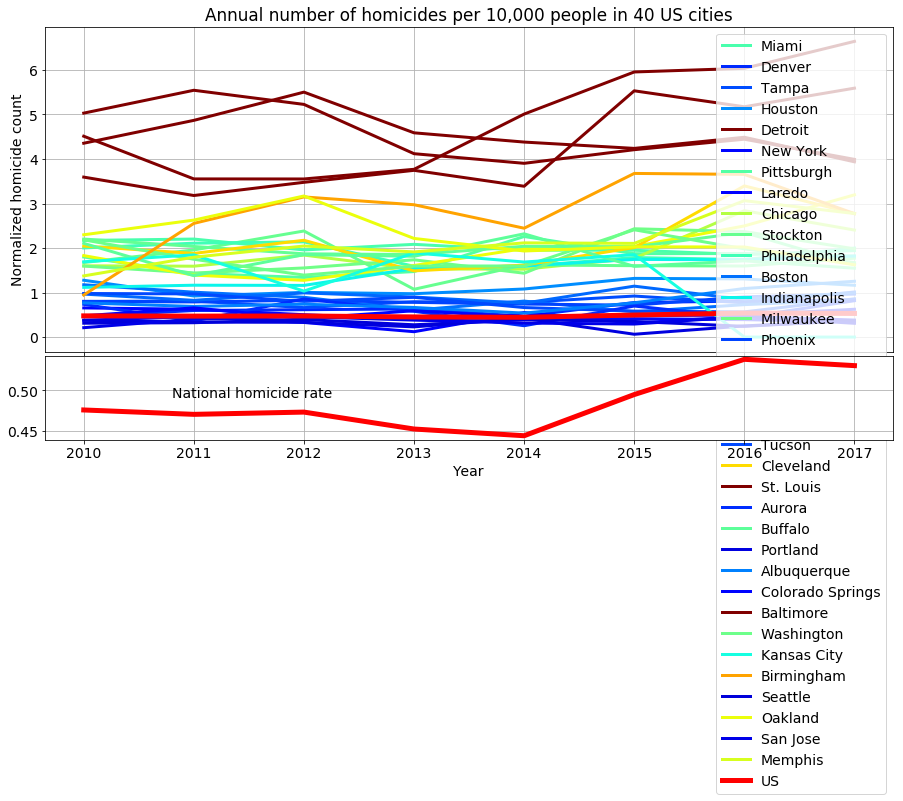

In [784]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(20,20)


plt.subplot(gs[0:15,0:19])
plt.grid()


cities = set(census_data_select['city'])
for city in cities:
    plt.plot(yearXcity_df.index,yearXcity_df[city],lw=3,c=city_colors[city])#,label=city)
    
plt.plot(fbi_national_ucr_since2010['year'],\
     fbi_national_ucr_since2010['homicide']/fbi_national_ucr_since2010['population']*10000,\
     color='r',lw=5,label='US')

plt.ylabel('Normalized homicide count')
plt.title('Annual number of homicides per 10,000 people in 40 US cities')

plt.legend()


plt.subplot(gs[15:19,0:19])
plt.grid()

plt.plot(fbi_national_ucr_since2010['year'],\
         fbi_national_ucr_since2010['homicide']/fbi_national_ucr_since2010['population']*10000,\
         color='r',lw=5)
plt.xlabel('Year')
plt.annotate('National homicide rate',xy=(0.15,0.50),xycoords='axes fraction')



# savefig("Figure_1_annual_homicide_rates.png", dpi=400)

In [625]:
my_variable_dictionary = {'B17002_001E': 'Ratio of income to poverty level',
 'B01002_001E': 'Median age total',
 'B01002_002E': 'Median age male',
 'B01002_003E': 'Median age female',
 'B19001_002E': 'Less than $10,000',
 'B19001_001E': 'Household income',
 'B19001_017E': '$200,000 or more',
 'B01001_026E': 'Female',
 'B01001_001E': 'Sex by age',
 'B01001_002E': 'Male',
 'B19058_003E': 'No cash public assistance or food stamps/snap',
 'B19058_001E': 'Public assistance income or food stamps/sap',
 'B19058_002E': 'With cash public assistance or food stamps/snap',
 'B19301_001E': 'Per capita income ',
 'B19113_001E': 'Median family income ',
 'B01003_001E': 'Total population',
 'B07411_001E': 'Median income total living in area 1 year ago',
 'B02001_002E': 'White alone',
 'B02001_001E': 'Race',
 'B02001_004E': 'American indian and alaska native alone',
 'B02001_003E': 'Black or african american alone',
 'B02001_006E': 'Native hawaiian and other pacific islander alone',
 'B02001_005E': 'Asian alone'}

my_variable_dictionary

{'B17002_001E': 'Ratio of income to poverty level',
 'B01002_001E': 'Median age total',
 'B01002_002E': 'Median age male',
 'B01002_003E': 'Median age female',
 'B19001_002E': 'Less than $10,000',
 'B19001_001E': 'Household income',
 'B19001_017E': '$200,000 or more',
 'B01001_026E': 'Female',
 'B01001_001E': 'Sex by age',
 'B01001_002E': 'Male',
 'B19058_003E': 'No cash public assistance or food stamps/snap',
 'B19058_001E': 'Public assistance income or food stamps/sap',
 'B19058_002E': 'With cash public assistance or food stamps/snap',
 'B19301_001E': 'Per capita income ',
 'B19113_001E': 'Median family income ',
 'B01003_001E': 'Total population',
 'B07411_001E': 'Median income total living in area 1 year ago',
 'B02001_002E': 'White alone',
 'B02001_001E': 'Race',
 'B02001_004E': 'American indian and alaska native alone',
 'B02001_003E': 'Black or african american alone',
 'B02001_006E': 'Native hawaiian and other pacific islander alone',
 'B02001_005E': 'Asian alone'}

### GARBAGE

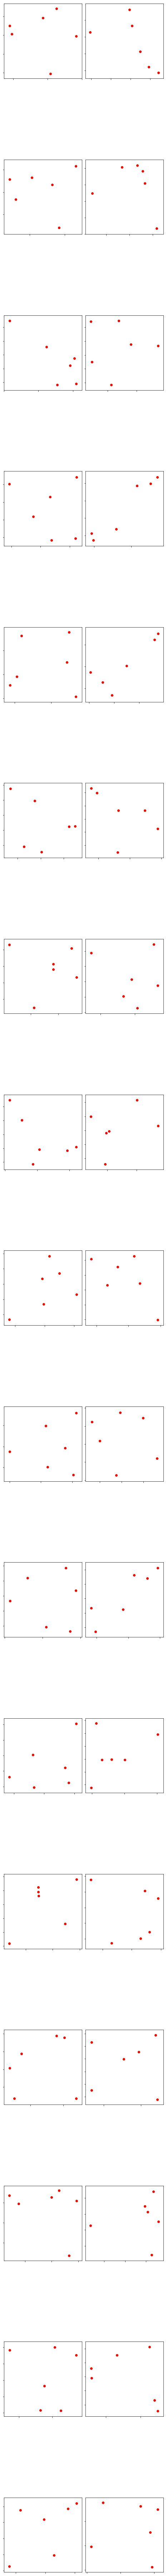

In [377]:
eig_vecs_6 = [v for k,v in eig_dict.items()]
city_weights = np.column_stack(eig_vecs_6)

n_features = 35


# SET FIGURE SIZE AND GRID DIMENSIONS
matplotlib.rcParams.update({'font.size': 16})

fig_length = 4*n_features
fig_width = 8
number_of_plots = n_features
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(fig_width,fig_length))
gs = gridspec.GridSpec(fig_length,fig_width)


for n,i,j in zip(arange(number_of_plots),city_weights[:-1],city_weights[1:]):

    if n % 2 == 0:
        w_start = 0
        w_end = int(fig_width/2)
        l_start = math.floor(plot_length * n)
        l_end = math.floor(plot_length * (n+1))
    else:
        w_start = int(fig_width/2)
        w_end = fig_width
    
    

    
    ax = subplot(gs[l_start:l_end,w_start:w_end])
    
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    plt.scatter(i,j,c=c)

AttributeError: 'numpy.ndarray' object has no attribute 'components_'

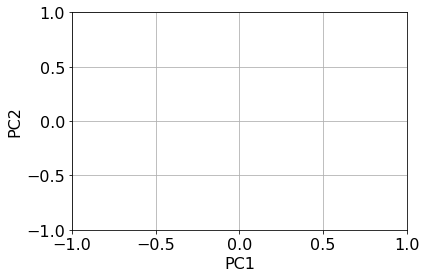

In [330]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_std[:,0:2],np.transpose(result.components_[0:2, :]))
plt.show()


15.17358779041949
-0.0016373960789965163
Minneapolis

6.475352706267845
0.03596610484327963
Tampa

4.959585282170628
-0.017224381286786265
Tampa

4.7301604215099475
0.004198453397794018
Tampa

3.8964864728339386
0.007423716687148597
Buffalo

3.0970772766872217
0.00432767019602268
Miami


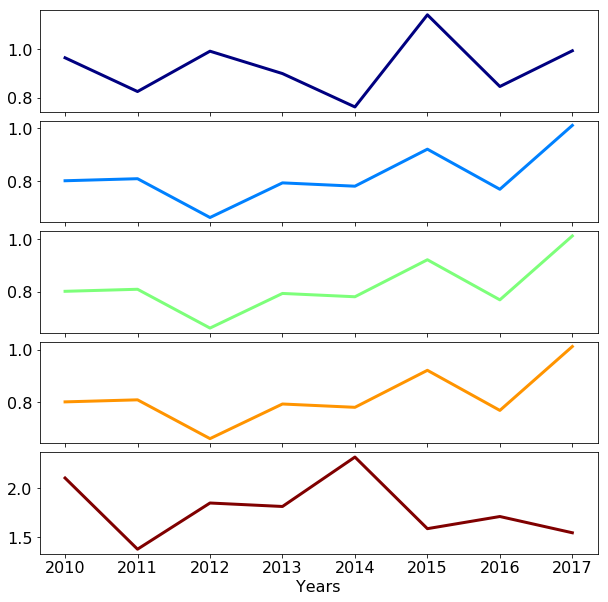

In [257]:


plot_cities = []
for k,v in eig_dict.items():
    print()
    print(k)
    print(median(v))
    city_with_highest_correlation = list(yearXcity)[[i for i,x in enumerate(v) if x == median(v)][0]][1]
    print(city_with_highest_correlation)
    plot_cities.append(city_with_highest_correlation)

    
    
# SET FIGURE SIZE AND GRID DIMENSIONS
matplotlib.rcParams.update({'font.size': 16})

fig_length = 2*n_features
number_of_plots = n_features
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(10,fig_length))
gs = gridspec.GridSpec(fig_length,number_of_plots)


for n,pc,c in zip(arange(n_features),plot_cities,plt.cm.jet(np.linspace(0,1,n_features))):
    
    start = math.floor(plot_length * n)
    end = math.floor(plot_length * (n+1))
    ax = subplot(gs[start:end,0:number_of_plots])
    
    x = sorted(years)
    y = list(yearXcity['normalized_actual',pc])
    plt.plot(x,y,lw=3,c=c)
    
    # LABEL AXES
    if n+1 != number_of_plots:
        ax.tick_params(labelbottom=False)   
    else:
        plt.xlabel('Years') 
        
#     plt.ylabel('Homicide rate')
#     plt.legend(loc='upper left', bbox_to_anchor=(0.64, 0.9), frameon=False)#, labelspacing=1.6)#, prop={'weight':'bold'})
    
#     ylim = ax.get_ylim()[1]
#     xlim = ax.get_xlim()[1]
#     print(ylim)
#     print(xlim)
#     plt.text(0.8*xlim,0.8*ylim,r'component' + str(n+1))
    

In [259]:
sklearn_eig_dict = dict(zip(variance[:6],vectors[:6]))
sklearn_eig_dict

{15.173587790419479: array([ 0.20865489, -0.01365894,  0.03314501,  0.25983882,  0.15327545,
        -0.15894643, -0.07546657,  0.21461779,  0.18926181,  0.01824046,
         0.23065029, -0.17741294,  0.17598791,  0.2527374 , -0.1879497 ,
         0.01636625,  0.23908072,  0.2330692 , -0.20828025,  0.23609556,
         0.07786578, -0.18647763, -0.21264806, -0.20378629, -0.0926512 ,
         0.13822163,  0.1277603 , -0.10728043,  0.00123785, -0.05146465,
         0.25524251, -0.08166061,  0.16910353, -0.17614298,  0.08989604]),
 6.475352706267825: array([-0.22006125,  0.09962456, -0.18794908, -0.03458503, -0.0917065 ,
        -0.1167615 ,  0.24088816, -0.20475669, -0.2267798 , -0.09000952,
        -0.17206145, -0.20832217,  0.09664787,  0.10846159,  0.2425828 ,
         0.00994493, -0.0069536 , -0.13122778,  0.03060618, -0.00158721,
        -0.05492727, -0.23590051, -0.06695306, -0.20371219, -0.32288737,
        -0.27982412,  0.27853578, -0.06378696, -0.24866239, -0.0122136 ,
         0

In [ ]:
# SET FIGURE SIZE AND GRID DIMENSIONS
matplotlib.rcParams.update({'font.size': 28})

fig_length = 12
number_of_plots = len(census_data)
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(10,fig_length))
gs = gridspec.GridSpec(fig_length,number_of_plots)

for year in sorted(list(years)):
    sub_df = census_data[census_data['year']==year]
    for col in list(census_data):

        start = math.floor(plot_length * n)
        end = math.floor(plot_length * (n+1))
        ax = subplot(gs[start:end,0:number_of_plots])

        
        x = sorted(list(years))
        y = result[:,n]
        plt.plot(x,y,lw=3,c=c)

        # LABEL AXES
        if n+1 != number_of_plots:
            ax.tick_params(labelbottom=False)   
        else:
            plt.xlabel('Years') 


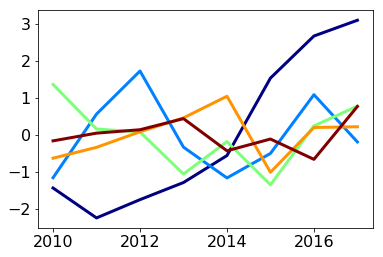

In [178]:
# for n,c in zip(np.arange(n_features),plt.cm.jet(np.linspace(0,1,n_features))):
#     x = sorted(list(years))
#     y = result[:,n]
#     plt.plot(x,y,lw=3,c=c)

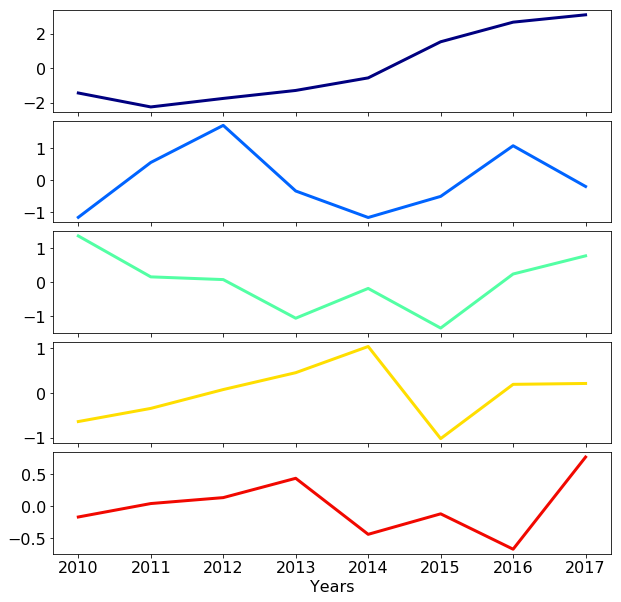

In [284]:
n_features = 5
pca_result = PCA(n_components=n_features)
result = pca_result.fit_transform(pca_homicide_input)

# assign colors to cities

city_colors = {}
city_hom_ave = {}
for city in cities:
    city_df = homicides[homicides['city']==city]
    calc_color = plt.cm.jet(city_df['normalized_actual'].max()/5)
    city_colors[city] = calc_color
    city_hom_ave[city] = city_df['normalized_actual'].mean()
#     plt.plot(city_df['data_year'],city_df['normalized_actual'],lw=3,c=calc_color)#,label=city)


# SET FIGURE SIZE AND GRID DIMENSIONS
matplotlib.rcParams.update({'font.size': 16})

fig_length = 2*n_features
number_of_plots = n_features
plot_length = fig_length/number_of_plots

fig, ax = plt.subplots(figsize=(10,fig_length))
gs = gridspec.GridSpec(fig_length,number_of_plots)


for n,c in zip(np.arange(n_features),plt.cm.jet(np.linspace(0,0.9,n_features))):
    
    start = math.floor(plot_length * n)
    end = math.floor(plot_length * (n+1))
    ax = subplot(gs[start:end,0:number_of_plots])
    
    x = sorted(list(years))
    y = result[:,n]
    plt.plot(x,y,lw=3,c=c)
    
    # LABEL AXES
    if n+1 != number_of_plots:
        ax.tick_params(labelbottom=False)   
    else:
        plt.xlabel('Years') 
        
#     plt.ylabel('Homicide rate')
#     plt.legend(loc='upper left', bbox_to_anchor=(0.64, 0.9), frameon=False)#, labelspacing=1.6)#, prop={'weight':'bold'})
    
#     ylim = ax.get_ylim()[1]
#     xlim = ax.get_xlim()[1]
#     print(ylim)
#     print(xlim)
#     plt.text(0.8*xlim,0.8*ylim,r'component' + str(n+1))
    